# Laboratorio: Classificazione

**Programmazione di Applicazioni Data Intensive**  
Laurea in Ingegneria e Scienze Informatiche  
DISI - Università di Bologna, Cesena

Proff. Gianluca Moro, Roberto Pasolini  
nome.cognome@unibo.it

In [1]:
# setup e test librerie
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

## Classificazione

- Nei problemi visti finora di _regressione_, l'obiettivo è prevedere il valore di una variabile _continua_
  - una quantità di energia consumata, il prezzo di una casa, ...
- Nei problemi di **_classificazione_** l'obiettivo generale è invece, per ogni osservazione, **distinguere uno di due o più casi (_classi_) possibili**
- Come per la regressione, un modello di classificazione va addestrato su esempi già correttamente classificati

## Caso di studio: Diagnostica per immagini

- Data un'immagine di cellule tumorali estratte da un paziente, si vogliono classificare queste come benigne o maligne
- Da ciascuna cellula possono essere estratte delle caratteristiche
  - dimensione, concavità, consistenza, ...
- Dall'immagine intera possiamo estrarre statistiche su ciascuna di queste caratteristiche
- Vogliamo addestrare un modello a classificare ciascuna immagine sulla base di queste caratteristiche

_Immagini da cui sono estratte le righe 92751 e 927241 del dataset_

![immagine cellule](http://web.archive.org/web/19970511062136/http://www.cs.wisc.edu/~street/images/92_751.gif)
![immagine cellule](http://web.archive.org/web/19970511062136/http://www.cs.wisc.edu/~street/images/92_7241.gif)

- Utilizziamo il [Breast Cancer Wisconsin (Diagnostic) Data Set](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29), in cui ogni osservazione contiene le caratteristiche estratte da un'immagine
- Con `read_csv` possiamo importare il dataset direttamente in un frame pandas dato il suo URL
  - con `header=None` specifichiamo l'assenza di una riga header
  - la prima colonna contiene un ID univoco per osservazione, la impostiamo come indice

In [2]:
BCWDS_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data"
bcwds = pd.read_csv(BCWDS_URL, header=None, index_col=0)

In [3]:
bcwds.head(3)

,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
0,,,,,,,,,,,,,,,,,,,,,
842302,M,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
842517,M,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
84300903,M,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


- La prima colonna dei dati indica la classificazione delle cellule nell'immagine
  - M = maligne, B = benigne
- Le altre 30 colonne corrispondono alle variabili estratte dalle immagini
- Da ogni cellula in ogni immagine sono state estratte le seguenti caratteristiche
  - si veda la pagina del dataset per il significato di ciascuna

In [7]:
cell_features = ["radius",     "texture",
                 "perimeter",  "area",
                 "smoothness", "compactness",
                 "concavity",  "concave_pts",
                 "symmetry",   "fractal_dim"]

- Sull'insieme delle cellule sono estratte tre statistiche per ciascuna caratteristica: la media, la deviazione standard e la media dei tre valori più alti ("worst")

In [8]:
stats = ["mean", "std", "worst"]

- Assegniamo i nomi alle colonne del frame, generandoli dalle due liste sopra con due cicli innestati

In [9]:
bcwds.columns = ["diagnosis"] + [f"{stat}_{feat}" for stat in stats for feat in cell_features]

- Abbiamo così il frame con nomi leggibili per le colonne
- Di default pandas visualizza al massimo 20 colonne (prime 10 e ultime 10): il seguente comando aumenta tale limite
  - ci sono [varie altre opzioni](https://pandas.pydata.org/docs/user_guide/options.html) impostabili per la visualizzazione dei frame, ad es. `max_rows` per il numero di righe

In [11]:
pd.options.display.max_columns = 31

In [10]:
bcwds.head(5)

,diagnosis,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_pts,mean_symmetry,...,worst_radius,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_pts,worst_symmetry,worst_fractal_dim
0,,,,,,,,,,,,,,,,,,,,,
842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## Esercizio 1: Analisi esplorativa

- **(1a)** Stampare il numero di valori "M" e "B" della variabile `diagnosis`
- **(1b)** Rappresentare la distribuzione di valori di `diagnosis` in un diagramma a torta
- **(1c)** Visualizzare le statistiche principali (media, dev. standard, ...) delle 10 variabili `mean_*`
  - si trovano dalla 2ᵃ all'11ᵃ colonna del frame
- **(1d)** Rappresentare la distribuzione di valori di `mean_area` in un'istogramma a 20 intervalli
- **(1e)** Rappresentare la distribuzione congiunta di `mean_area` e `mean_concave_pts` in un grafico a dispersione

In [27]:
bcwds['diagnosis'].value_counts(normalize=True)

B    0.627417
M    0.372583
Name: diagnosis, dtype: float64

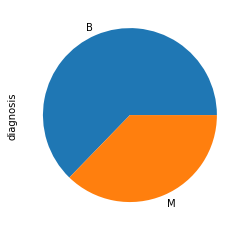

In [17]:
bcwds['diagnosis'].value_counts().plot.pie();

In [35]:
#bcwds.iloc[:, 1:11].agg(['mean','std'])

In [31]:
bcwds.iloc[:, 1:11].describe()

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_pts,mean_symmetry,mean_fractal_dim
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440


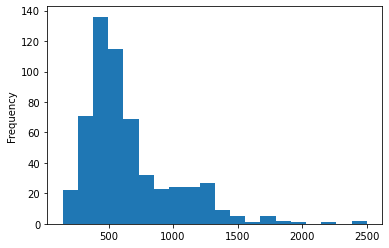

In [33]:
bcwds['mean_area'].plot.hist(bins=20);

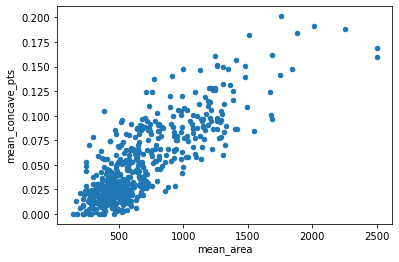

In [34]:
bcwds.plot.scatter("mean_area","mean_concave_pts");

## Distribuzione valori suddivisi per classi

- In un problema di classificazione, è utile visualizzare quanto le variabili predittive siano correlate con la classe da predire
- Negli ultimi punti dell'esercizio abbiamo generato grafici con la distribuzione delle variabili, ignorando la classe di appartenenza
- Vogliamo ora integrare l'informazione della classe negli stessi grafici, per valutare quanto le variabili siano utili nella predizione della classe

- Visualizziamo un'istogramma _stacked_ di `mean_area`, in cui in ogni intervallo si vede la suddivisione dei valori tra le due classi
  - con `pivot(columns="diagnosis")` sdoppiamo ciascuna colonna nel frame, suddividendo i valori relativi alle classi B e M
  - con `["mean_area"]` selezioniamo le due colonne `("mean_area", *)`
  - visualizziamole in un'istogramma, specificando `stacked=True` per far sì che le barre delle due colonne siano poste una sopra l'altra

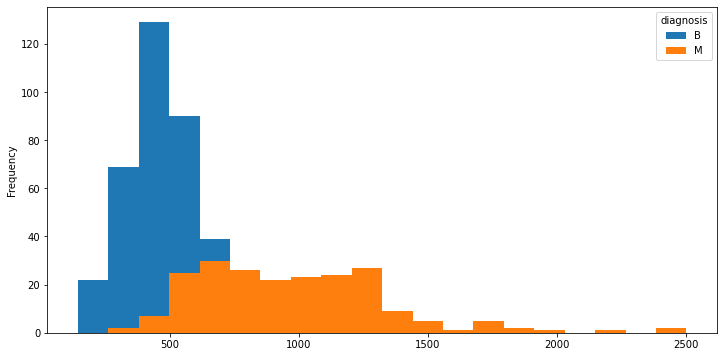

In [37]:
bcwds.pivot(columns="diagnosis")["mean_area"].plot.hist(bins=20, stacked=False, figsize=(12, 6));

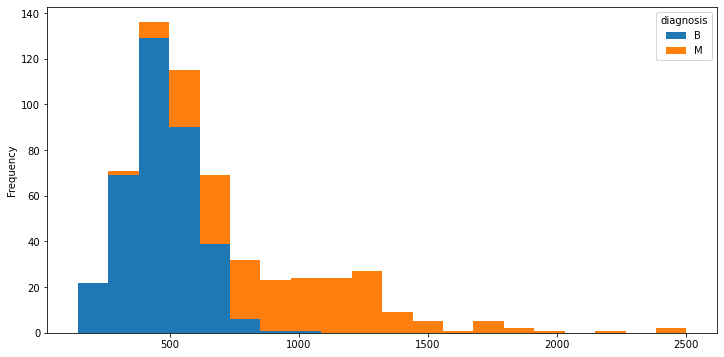

In [38]:
bcwds.pivot(columns="diagnosis")["mean_area"].plot.hist(bins=20, stacked=True, figsize=(12, 6));

- Questo grafico evidenzia ad es. che la `mean_area` è tendenzialmente bassa nei casi B e alta nei casi M

- Possiamo evidenziare le classi anche nei diagrammi a dispersione con la distribuzione tra due variabili, differenziando i punti ad es. per colore
- Definiamo in un dizionario che associ un colore a ciascuna classe

In [39]:
diagnosis_color_map = {"B": "blue", "M": "red"}

- Col metodo `map`, convertiamo ciascun elemento in una serie (o frame) secondo un dizionario dato

In [40]:
diagnosis_colors = bcwds["diagnosis"].map(diagnosis_color_map)

- Otteniamo così una serie di valori "red" e "blue"

In [41]:
diagnosis_colors.tail(4)

0
926682     red
926954     red
927241     red
92751     blue
Name: diagnosis, dtype: object

- Usiamo questa serie come parametro `c` nel metodo `plot.scatter` per assegnare un colore differenziato ai punti del grafico a dispersione

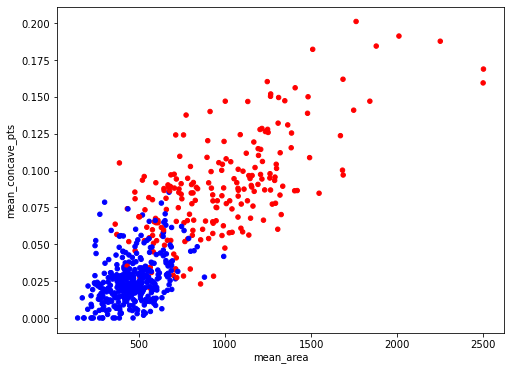

In [42]:
bcwds.plot.scatter("mean_area", "mean_concave_pts", c=diagnosis_colors, figsize=(8, 6));

## Classificazione lineare

- Come per la regressione, anche per la classificazione i metodi più semplici si basano su modelli con relazioni lineari tra le variabili
- Un classificatore a due classi _lineare_ è definito da un **iperpiano** che separa lo spazio delle variabili in due _semispazi_
  - la classe prevista per un'osservazione (un punto) dipende dal semispazio in cui si trova
- Se consideriamo uno spazio di due variabili (un piano), questo significa in pratica tracciare una retta che separi una classe dall'altra

- Consideriamo ad esempio il piano visualizzato sopra con le due variabili `mean_area` e `mean_concave_pts` e le osservazioni differenziate per classe
- Selezioniamo i dati su cui lavorare
  - la variabile `y` da predire è la classe: B (benigno) o M (maligno)
  - le variabili `X` sono `mean_area` ($x_1$) e `mean_concave_pts` ($x_2$), per ora ignoriamo le altre variabili

In [43]:
y = bcwds["diagnosis"]
X2d = bcwds[["mean_area", "mean_concave_pts"]]

- Suddividiamo come al solito i dati in un training set e in un validation set con la funzione `train_test_split`

In [44]:
from sklearn.model_selection import train_test_split

X2d_train, X2d_val, y_train, y_val = train_test_split(
    X2d, y,           # dati da suddividere
    test_size=1/3,    # proporzione: 2/3 training, 1/3 validation
    random_state=42   # seed per la riproducibilità
)

- Visualizziamo i dati di training su cui addestrare il classificatore
  - applichiamo ad `y_train` la mappa dei colori definita sopra

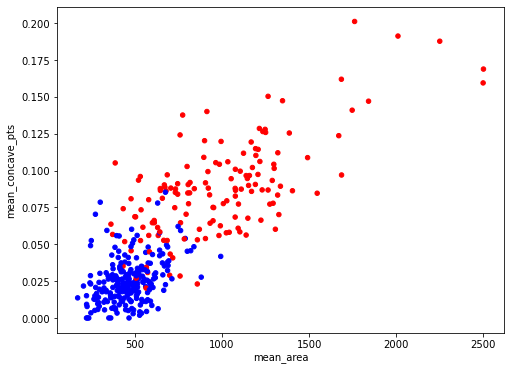

In [45]:
X2d_train.plot.scatter("mean_area", "mean_concave_pts", c=y_train.map(diagnosis_color_map), figsize=(8, 6));

- Per addestrare un classificatore lineare, dobbiamo individuare **una retta che separi i punti rossi dai punti blu**
- In seguito, ciascuna nuova osservazione sarà classificata "B" (blu) o "M" (rossa) a seconda del lato della retta su cui si trova
- Ipotizziamo ad esempio di utilizzare come separatore la retta descritta dall'equazione
$$ x_2 = -0.0001\cdot x_1+0.15 $$
- Possiamo rappresentare la retta sovrapposta ai dati similmente a come abbiamo fatto per i modelli di regressione
  - campioniamo una serie di valori campione per $x_1$ (essendo una retta bastano i due estremi)
  - estraiamo i valori corrispondenti di $x_2$

In [47]:
sep_x1 = np.linspace(0, 1500, 2)
sep_x2 = -0.0001 * sep_x1 + 0.15

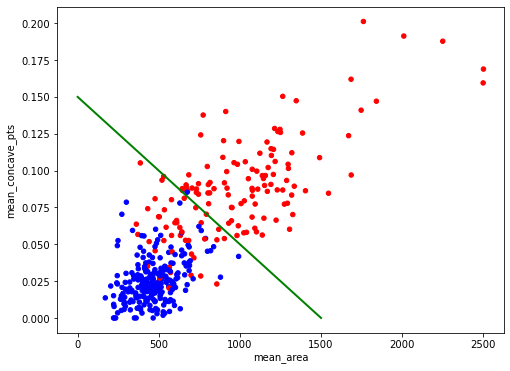

In [48]:
X2d_train.plot.scatter("mean_area", "mean_concave_pts", c=y_train.map(diagnosis_color_map), figsize=(8, 6))
plt.plot(sep_x1, sep_x2, c="green", linewidth=2);

- Assumiamo questa retta come modello di classificazione, classificando come B i punti al di sotto e come M quelli sopra

## Esercizio 2: Estrazione predizioni classificazione

- Creare un array `y_pred` che indichi la classe predetta (`"M"` o `"B"`) per ciascuna osservazione del validation set `X2d_val`
- Consiglio: servirsi della funzione `np.where(B, xt, xf)`, che dato un array (o serie) booleano `B` ne restituisce uno di pari lunghezza con i valori `xt` e `xf` al posto di `True` e `False`

In [72]:
above_the_line = X2d_val["mean_concave_pts"] > -0.0001 * X2d_val["mean_area"] + 0.15
y_pred = np.where(above_the_line, "M", "B")
print(y_pred)

['B' 'M' 'M' 'B' 'B' 'M' 'M' 'M' 'B' 'B' 'B' 'M' 'B' 'M' 'B' 'M' 'B' 'B'
 'B' 'M' 'B' 'B' 'M' 'B' 'B' 'B' 'B' 'B' 'B' 'M' 'B' 'B' 'B' 'B' 'B' 'B'
 'B' 'B' 'M' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'M' 'M' 'B' 'B'
 'B' 'B' 'B' 'M' 'B' 'B' 'B' 'M' 'M' 'B' 'B' 'B' 'M' 'M' 'B' 'B' 'B' 'B'
 'B' 'M' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'M' 'B' 'M' 'B' 'M' 'B' 'B'
 'B' 'B' 'B' 'B' 'B' 'B' 'M' 'M' 'B' 'M' 'B' 'B' 'M' 'M' 'B' 'B' 'B' 'M'
 'B' 'B' 'B' 'B' 'B' 'M' 'B' 'M' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'M' 'B' 'M'
 'M' 'B' 'B' 'M' 'M' 'M' 'B' 'B' 'B' 'M' 'B' 'B' 'B' 'B' 'B' 'M' 'B' 'B'
 'B' 'B' 'M' 'M' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'M' 'M' 'B' 'B' 'B' 'B' 'B'
 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B'
 'B' 'B' 'B' 'B' 'M' 'B' 'B' 'B' 'M' 'B']


## Accuratezza delle predizioni

- Per confrontare diversi classificatori, vogliamo una misura quantitativa della loro bontà
- Nella predizione di valori continui (regressione), possiamo valutare un modello in base a quanto ciascun valore predetto si avvicini a quello reale
  - questo è misurato con metriche quali ad es. MSE o R²
- Nella classificazione, possiamo valutare direttamente se le classi predette coincidano o meno con quelle reali
- Definiamo come **accuratezza** la percentuale di osservazioni del validation set di cui il modello predice correttamente la classe

## Esercizio 3: Calcolo dell'accuratezza

- **(3a)** Estrarre un array booleano `correct_class` che indichi per quali osservazioni del validation set la classe indicata in `y_pred` è corretta
- **(3b)** Da questo calcolare l'accuratezza, ovvero la percentuale di classificazioni corrette

In [75]:
correct_class = y_pred==y_val

In [74]:
mm = correct_class.mean()
print(mm)

0.8789473684210526


## Modelli di classificazione lineari

- Abbiamo validato un modello di classificazione individuato "ad occhio", vediamo ora come addestrarne uno in modo automatico
- Un modello di classificazione lineare a $n$ variabili $x_1,\ldots,x_n$ consiste in generale nell'individuare un iperpiano di classificazione descritto dall'equazione:
$$ w_1\cdot x_1+\ldots+w_n\cdot x_n+b = 0 $$
- In forma vettoriale:
$$ \mathbf{w}\cdot\mathbf{x}+b = 0 $$
- L'addestramento del modello consiste nel determinare valori ottimali per il vettore $\mathbf{w}$ (_weights_, pesi) e per il termine $b$ (_bias_, distanza dell'iperpiano dall'origine)

## Perceptron

- Il _perceptron_ è un algoritmo di apprendimento molto semplice, concettualmente simile alla discesa gradiente
  - i parametri $\mathbf{w}$ e $b$ sono inizializzati casualmente
  - si itera il training set: per ogni istanza mal classificata, i parametri vengono aggiornati proporzionalmente ai valori di $\mathbf{x}$ e ad un _learning rate_ preimpostato
  - si possono eseguire molteplici iterazioni del training set
- Per creare un modello perceptron, come per i modelli di regressione, iniziamo creando un'istanza della classe `Perceptron`
  - ci sono diversi parametri impostabili per ottenere varianti (es. con regolarizzazione), ma quì non le consideriamo

- Prima di procedere, dato che le variabili `mean_area` e `mean_concave_pts` hanno scale molto diverse, ne effettuiamo la standardizzazione (media 0 e dev. standard 1)
  - evitiamo per ora di utilizzare una pipeline, per analizzare più agevolmente il modello
- Utilizziamo un filtro `StandardScaler` per ottenere gli array `X2dn_train` e `X2dn_val` con i dati in `X2d_train` e `X2d_val` standardizzati

In [82]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X2dn_train = scaler.fit_transform(X2d_train)
X2dn_val = scaler.transform(X2d_val)

- Visualizziamo in un grafico a dispersione i dati standardizzati `X2dn_train` con classi differenziate
  - si ottiene una figura identica a quella dei dati non standardizzati, con solamente gli intervalli degli assi cambiati

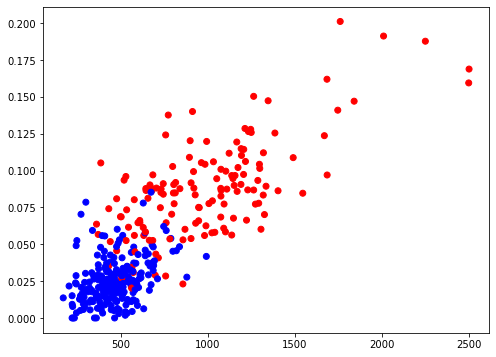

In [94]:
# gradico dei dati non normalizzati
plt.figure(figsize=(8, 6))
plt.scatter(X2d_train.values[:, 0], X2d_train.values[:, 1], c=y_train.map(diagnosis_color_map));

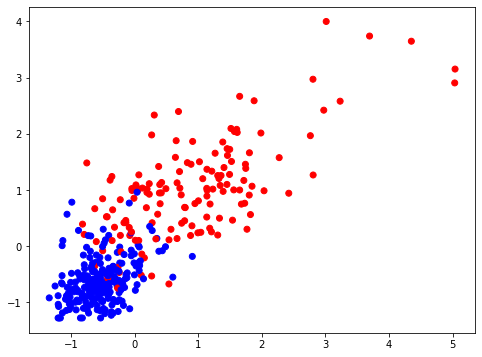

In [98]:
plt.figure(figsize=(8, 6))
plt.scatter(X2dn_train[:, 0], X2dn_train[:, 1], c=y_train.map(diagnosis_color_map));

- Creiamo un modello `Perceptron`

In [99]:
from sklearn.linear_model import Perceptron
model = Perceptron(random_state=42)

- Addestriamo il modello sul training set standardizzato
  - come nei modelli di regressione, passiamo separatamente i valori delle variabili predittive (X) e quelli della variabile da predire (y)

In [100]:
model.fit(X2dn_train, y_train)

Perceptron(random_state=42)

- Una volta addestrato il modello, possiamo trovare i valori dei pesi $\mathbf{w}$ e del bias $b$ rispettivamente negli attributi `coef_[0]` e `intercept_[0]`
  - lo `[0]` si riferisce al primo iperpiano, in questo caso è l'unico, in un modello a più di due classi sarebbero molteplici

In [101]:
model.coef_[0]

array([0.55782253, 1.686364  ])

In [103]:
model.intercept_[0]

-1.0

- Ad esempio questi coefficienti indicano che l'iperpiano individuato dal modello è descritto dall'equazione
$$ 0.558x_1+1.686x_2-1 = 0 $$
- L'attributo `classes_` mostra le classi riconosciute dal classificatore
  - la prima è quella a cui sono assegnati i punti sotto la retta, la seconda quella a cui sono assegnati i punti sopra

In [104]:
model.classes_

array(['B', 'M'], dtype='<U1')

- Per visualizzare la retta del modello...
$$ w_1\cdot x_1+w_2\cdot x_2+b = 0 $$
- ...la esprimiamo nella forma $x_2=\ldots$
$$ x_2 = -\frac{w_1}{w_2}\cdot x_1-\frac{b}{w_2} $$
- Implementiamo una funzione `separator_2d` in modo che, dato un modello e un array di valori $x_1$, restituisca l'array di corrispondenti valori $x_2$

In [105]:
def separator_2d(model, x1):
    # ricaviamo w e b dal modello
    w = model.coef_[0]
    b = model.intercept_[0]
    # riportiamo in NumPy la formula sopra
    return -x1 * w[0] / w[1] - b / w[1]

- Creiamo una funzione per visualizzare la retta del modello sovrapposta al grafico a dispersione dei dati, simile a quella che utilizzavamo nella regressione

In [106]:
def plot_separator_on_data(X, y, model=None):
    X = np.array(X)
    colors = pd.Series(y).map(diagnosis_color_map)
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=colors)
    if model is not None:
        xlim, ylim = plt.xlim(), plt.ylim()
        sep_x = np.linspace(*xlim, 2)
        sep_y = separator_2d(model, sep_x)
        plt.plot(sep_x, sep_y, c="green", linewidth=2)
        plt.xlim(xlim); plt.ylim(ylim)

- Visualizziamo la retta di separazione sovrapposta al validation set

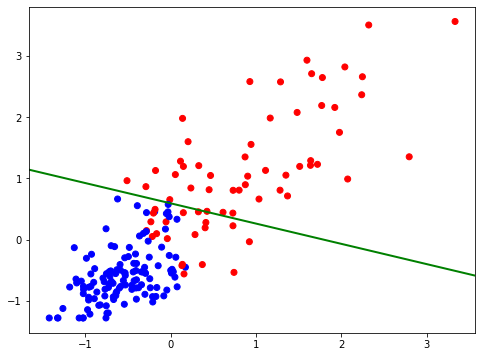

In [110]:
plot_separator_on_data(X2dn_val, y_val, model)

- Dal modello addestrato possiamo ottenere le predizioni per una o più osservazioni con `predict`
  - otteniamo ad esempio le predizioni per i primi 3 elementi del validation set

In [92]:
model.predict(X2dn_val[:3])

array(['B', 'M', 'M'], dtype='<U1')

- L'accuratezza definita sopra è la metrica predefinita per i modelli di classificazione: possiamo calcolarla col metodo `score`
  - come per calcolare R² nei modelli di regressione, passiamo X e y del validation set

In [111]:
model.score(X2dn_val, y_val)

0.8947368421052632

- Il modello classifica correttamente quasi il 90\% delle istanze del validation set

## Matrice di confusione, precision e recall

- Oltre all'accuratezza come percentuale di classificazioni corrette, esistono altri modi per valutare l'accuratezza di un classificatore
  - particolarmente utili in caso di sbilanciamento tra le classi, per cui l'accuratezza può non essere un indicatore affidabile
- Confrontando le classi predette da un classificatore su un set di dati con quelle reali, possiamo ottenere una **_matrice di confusione_**
- Ogni cella in riga i e colonna j indica quanti esempi della classe i-esima sono stati etichettati dal classificatore come di classe j-esima
  - lungo la diagonale (i=j) abbiamo quindi le quantità di classificazioni corrette, al di fuori abbiamo invece le quantità di errori

- Otteniamo la matrice col metodo `confusion_matrix`, passando i vettori di classi reali e predette

In [112]:
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X2dn_val)
cm = confusion_matrix(y_val, y_pred)

- Otteniamo la matrice in forma di array NumPy

In [113]:
cm

array([[122,   0],
       [ 20,  48]], dtype=int64)

- Per maggiore chiarezza, inseriamo i valori in un frame etichettando righe e colonne con i nomi delle classi

In [114]:
pd.DataFrame(cm, index=model.classes_, columns=model.classes_)

,B,M
B,122,0
M,20,48


- La matrice ad esempio ci indica che, di 68 esempi di immagini di cellule maligne (seconda riga) presenti nel validation set
  - 48 sono state correttamente etichettate come tali
  - 20 sono state erroneamente etichettate come benigne
- L'accuratezza si può ottenere dalla matrice di confusione come somma dei valori nella diagonale divisa per la somma complessiva

In [115]:
cm.diagonal().sum() / cm.sum()

0.8947368421052632

- Dalla sola matrice di confusione possiamo ricavare altre misure di performance importanti
- Presa una classe di riferimento, ad es. "M" (cellule maligne), la **_precision_** indica la percentuale di esempi classificati come "M" che sono realmente tali

In [116]:
#        quante istanze del validation set sono PREDETTE "M"
#                          ^^^^^^^^^^^^^^
malignant_prc = cm[1, 1] / cm[:, 1].sum()
malignant_prc

1.0

- Di contro, la **_recall_** indica la percentuale di esempi realmente di classe "M" che sono stati rilevati essere tali dal modello

In [117]:
#        quante istanze del validation set sono REALMENTE "M"
#                          ^^^^^^^^^^^^^^
malignant_rec = cm[1, 1] / cm[1, :].sum()
malignant_rec

0.7058823529411765

- Precision e recall sono quindi due indicatori complementari della bontà di un modello
- Generalmente, tarando il modello per migliorarne uno, l'altro peggiora
- Come misura unica della performance di un modello è spesso usata quindi la **_F1-measure_**, ovvero la media armonica tra precision e recall
$$ F_1 = \frac{2\cdot P\cdot R}{P+R} $$

In [118]:
2 * malignant_prc * malignant_rec / (malignant_prc + malignant_rec)

0.8275862068965517

- Per calcolare direttamente tali misure, scikit-learn fornisce le funzioni `precision_score`, `recall_score` e `f1_score`
  - col parametro `pos_label` si indica la classe di riferimento
  - si può in alternativa ottenere un vettore di punteggi per tutte le classi (`average=None`) o la loro media (`average="macro"`)

In [119]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [120]:
precision_score(y_val, y_pred, pos_label="M")

1.0

In [121]:
recall_score(y_val, y_pred, pos_label="M")

0.7058823529411765

In [53]:
f1_score(y_val, y_pred, average=None)

array([0.92424242, 0.82758621])

In [54]:
f1_score(y_val, y_pred, average="macro")

0.875914315569488

## Regressione Logistica

- La regressione _logistica_ è un modello di classificazione binaria basato sulla regressione lineare
- Sia data una variabile y pari a 1 per gli esempi di una classe (positiva) e -1 per quelli dell'altra (negativa), si minimizza la funzione
$$ \sum_{i=1}^n \log(\exp(- y_i (X_i^T w + c)) + 1) $$
- Per addestrare tale modello, creiamo un oggetto `LogisticRegression`
  - `random_state` indica il seed per la casualità usato nell'addestramento
  - `solver` indica quale implementazione utilizzare tra [diverse disponibili](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression) per l'addestramento, `"saga"` è l'unica che supporta tutte le opzioni per la regolarizzazione (che vediamo sotto)

In [122]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver="saga", random_state=42)

- Come sopra, addestriamo il modello sui dati già standardizzati

In [123]:
model.fit(X2dn_train, y_train)

LogisticRegression(random_state=42, solver='saga')

- Anche quì possiamo accedere ai parametri del modello addestrato e usarli per visualizzare il piano di separazione

In [124]:
model.coef_[0]

array([1.77607177, 2.9625736 ])

In [125]:
model.intercept_[0]

-0.32964982072959786

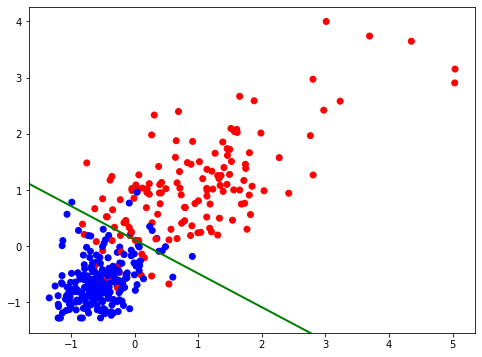

In [126]:
plot_separator_on_data(X2dn_train, y_train, model)

- La funzione logistica del modello restituisce la probabilità di appartenenza ad una classe (quella considerata "positiva")
  - sia essa p, quella per la negativa è implicitamente 1-p
- Date delle osservazioni da classificare, possiamo ottenere per ciascuna la distribuzione di probabilità tra le classi
  - possiamo in pratica vedere quanto il classificatore sia "sicuro" della classe da assegnare
- Passiamo le osservazioni al metodo `predict_proba`, ad es. le prime 3 del validation set: otteniamo una riga per ciascuna con le probabilità delle due classi
  - possiamo verificare l'ordine delle classi in `classes_`

In [127]:
model.classes_

array(['B', 'M'], dtype=object)

In [128]:
model.predict_proba(X2dn_val[:3])

array([[0.88335058, 0.11664942],
       [0.01288568, 0.98711432],
       [0.06982745, 0.93017255]])

- Ad esempio la prima osservazione è "B" con probabilità 88\%, mentre la seconda è "M" con probabilità 99\%

- Possiamo visualizzare in un grafico i dati sovrapposti al valore di probabilità restituito dal modello nello spazio dei dati

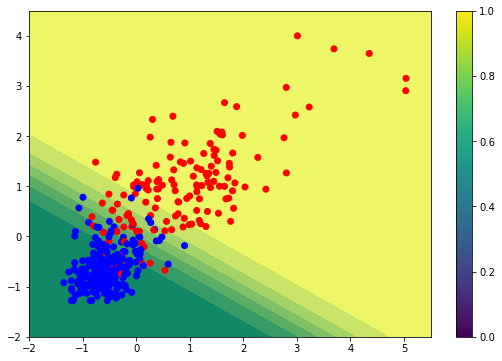

In [130]:
# estraggo un campione di 100x100 punti nel piano
mx1, mx2 = np.meshgrid(np.linspace(-2, 5.5, 100), np.linspace(-2, 4.5, 100))
# estraggo le probabilità della classe M per ciascun punto
my = model.predict_proba(np.c_[mx1.ravel(), mx2.ravel()])[:, 1].reshape(mx1.shape)
# disegno il grafico
plt.figure(figsize=(9, 6))
plt.contourf(mx1, mx2, my, cmap="summer")
plt.scatter(*X2dn_train.T, c=y_train.map(diagnosis_color_map))
plt.colorbar();

## Esercizio 4: Accuratezza del modello

In riferimento al modello di regressione logistica, calcolare sul validation set:
- **(4a)** l'accuratezza del modello
- **(4b)** la matrice di confusione
- **(4c)** la F1-measure relativa alla classe "M"

In [134]:
model.score(X2dn_val, y_val)

0.9

In [136]:
confusion_matrix(y_val, model.predict(X2dn_val))

array([[112,  10],
       [  9,  59]], dtype=int64)

In [137]:
# più leggibile
pd.DataFrame(confusion_matrix(y_val, model.predict(X2dn_val)), index=model.classes_, columns=model.classes_)

,B,M
B,112,10
M,9,59


In [138]:
f1_score(y_val, y_pred, average="macro")

0.875914315569488

## Regolarizzazione

- Anche nella regressione logistica possiamo applicare le tecniche di regolarizzazione viste nell'analisi di regressione
- Di default nella classe `LogisticRegression` viene applicata la regolarizzazione L2, che mantiene limitati i pesi in $\mathbf{w}$
  - questo impedisce che a singole variabili siano dati pesi molto grandi
- In `LogisticRegression` è possibile impostare un parametro `C`, che è il **reciproco** del peso della regolarizzazione (il parametro `alpha` visto in altre classi)
  - `C` è il _costo_ assegnato alle classificazioni sbagliate nella funzione d'errore da minimizzare

- Confrontiamo ad esempio tre modelli
  - il `model` addestrato sopra con `C=1` (default)
  - `model_high_C` con `C=1000` (scarsa regolarizzazione)
  - `model_low_C` con `C=0.001` (regolarizzazione intensa)

In [139]:
model_high_C = LogisticRegression(solver="saga", random_state=42, C=10000)
model_low_C = LogisticRegression(solver="saga", random_state=42, C=0.01)

- Addestriamo i due nuovi modelli sugli stessi dati a due variabili usati sopra

In [140]:
model_high_C.fit(X2dn_train, y_train)
model_low_C.fit(X2dn_train, y_train);

- Mettiamo a confronto i parametri dei tre modelli addestrati
  - creiamo una funzione per estrarli in forma di serie e la utilizziamo per costruire un frame

In [141]:
def params(model):
    return pd.Series(list(model.coef_[0]) + [model.intercept_[0]],
                     index=["w1", "w2", "b"])
models = {"low_C": model_low_C, "mid_C": model, "high_C": model_high_C}
pd.DataFrame({name: params(model) for name, model in models.items()})

,low_C,mid_C,high_C
w1,0.509911,1.776072,2.037397
w2,0.648664,2.962574,3.497886
b,-0.520482,-0.329650,-0.271896


- Si può notare che i pesi sono più alti per valori alti di C
- Mettendo a confronto le rette dei tre modelli si può notare che, al calare di C, la retta tende ad avere un'inclinazione di (-)45°, in quanto w1 e w2 tendono ad eguagliarsi

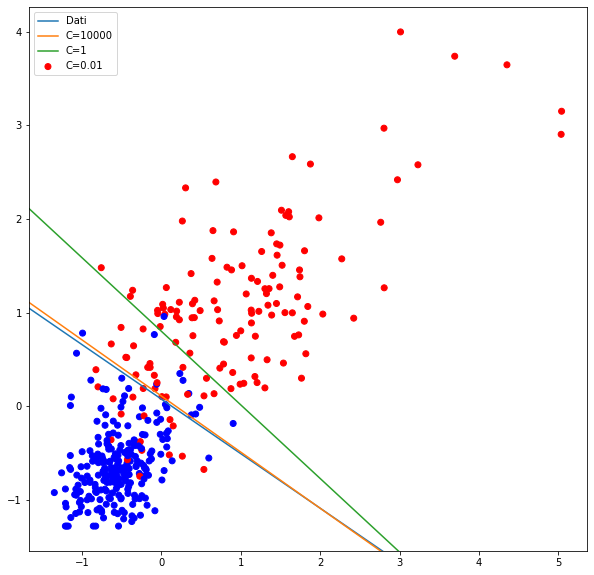

In [142]:
plt.figure(figsize=(10, 10))
plt.scatter(*X2dn_train.T, c=y_train.map(diagnosis_color_map))
xlim, ylim = plt.xlim(), plt.ylim()
sep_x = np.linspace(*xlim, 2)
sep_y_hc = separator_2d(model_high_C, sep_x)
sep_y_mc = separator_2d(model, sep_x)
sep_y_lc = separator_2d(model_low_C, sep_x)
plt.plot(sep_x, sep_y_hc)
plt.plot(sep_x, sep_y_mc)
plt.plot(sep_x, sep_y_lc)
plt.legend(["Dati", "C=10000", "C=1", "C=0.01"])
plt.xlim(xlim); plt.ylim(ylim);

- `LogisticRegression` supporta anche la regolarizzazione L1, che permette di azzerare i pesi delle variabili meno significative
- Possiamo applicarla al posto della L2 specificando `penalty="l1"`
- Addestriamo ad esempio un modello con regolarizzazione L1 e C basso

In [143]:
model = LogisticRegression(solver="saga", random_state=42, penalty="l1", C=0.01)
model.fit(X2dn_train, y_train);

- Vediamone i parametri

In [145]:
model.coef_[0]

array([0.        , 0.50493059])

In [146]:
model.intercept_[0]

-0.5089287059647748

- Il peso di una delle due variabili ($x_1$) è stato annullato per via della forte regolarizzazione

- In pratica la retta individuata dal modello è parallela all'asse $x_1$

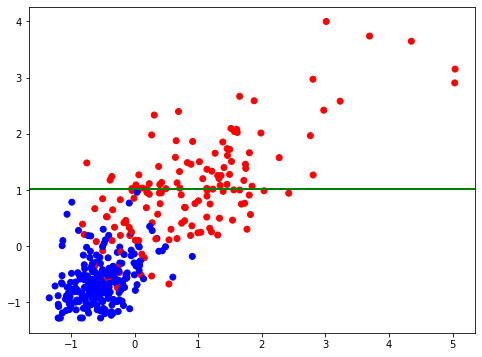

In [147]:
plot_separator_on_data(X2dn_train, y_train, model)

- Possiamo infine indicare `penalty="elasticnet"` per applicare entrambe le tecniche di regolarizzazione
  - con `C` si regola il peso complessivo dei due termini di regolarizzazione
  - possiamo decidere la proporzione tra le due tramite il parametro `l1_ratio`, funzionante come nel modello di regressione `ElasticNet`

In [148]:
model = LogisticRegression(
    solver="saga", random_state=42,
    penalty="elasticnet", C=0.1, l1_ratio=0.2)
model.fit(X2dn_train, y_train);

- In questo dataset relativamente semplice non si apprezzano particolari differenze nell'accuratezza

In [149]:
model.score(X2dn_val, y_val)

0.9

- È anche possibile disabilitare completamente la regolarizzazione con `penalty="none"`, in tal caso il parametro `C` è ininfluente

## Cross-validation su classificazione

- Abbiamo già visto la cross validation a k fold per la validazione di un modello
  - ciascun 1/k dei dati è testato su un modello addestrato sui restanti
- Dovendo addestrare un modello a riconoscere delle classi, è opportuno che le proporzioni di ciascuna classe nei fold siano uguali
- `StratifiedKFold` è una variante di `KFold` che garantisce uguale distribuzione delle classi tra un fold e l'altro
  - le opzioni impostabili sono le stesse (numero di fold e casualità)
- Per confronto, creiamo sia uno splitter `KFold` che uno `StratifiedKFold` con stessi parametri (3 fold)

In [77]:
from sklearn.model_selection import KFold, StratifiedKFold
kf = KFold(3, shuffle=True, random_state=42)
skf = StratifiedKFold(3, shuffle=True, random_state=42)

- Confrontando le distribuzioni delle classi nei validation set dei 3 fold, vediamo che con `StratifiedKFold` sono eque

In [78]:
# KFold
for train, val in kf.split(X2dn_train, y_train):
    print(y_train.iloc[val].value_counts())

B    75
M    52
Name: diagnosis, dtype: int64
B    75
M    51
Name: diagnosis, dtype: int64
B    85
M    41
Name: diagnosis, dtype: int64


In [79]:
# StratifiedKFold
for train, val in skf.split(X2dn_train, y_train):
    print(y_train.iloc[val].value_counts())

B    79
M    48
Name: diagnosis, dtype: int64
B    78
M    48
Name: diagnosis, dtype: int64
B    78
M    48
Name: diagnosis, dtype: int64


## Grid search con parametri opzionali

- Abbiamo visto come, data una "griglia" con liste di valori possibili per gli iperparametri di un modello, la grid search testi tutte le combinazioni possibili
- Esistono però casi in cui alcuni parametri sono significativi dipendentemente dai valori di altri
- Ad es. in `LogisticRegression` ha senso specificare `l1_ratio` solo se `penalty="elasticnet"`
- Per risolvere il problema, possiamo scomporre le combinazioni possibili su **più griglie di parametri**

- Ipotizziamo ad esempio di voler testare la `LogisticRegression` con:
  - regolarizzazione di tipo "l2", "l1" o "elasticnet"
  - parametro C pari a 0.1, 1 o 10
  - nel caso di "elasticnet", `l1_ratio` pari a 0.2 o 0.5
- Il modello base è dato da:

In [80]:
model = LogisticRegression(solver="saga", random_state=42)

- Un modo per testare tutte le combinazioni sarebbe:

In [81]:
grid = {
    "penalty": ["l2", "l1", "elasticnet"],
    "C": [0.1, 1, 10],
    "l1_ratio": [0.2, 0.5]
}

- La griglia genera un totale di 3×3×2=18 combinazioni
- Però i casi con regolarizzazione L2 e L1 sarebbero ripetuti con due valori possibili di `l1_ratio`, che non ha alcuna influenza
  - riceveremmo inoltre dei warning perché impostiamo inutilmente il parametro `l1_ratio`

- L'alternativa è scomporre i casi da provare in due griglie:
  - una con regolarizzazione L2 e L1 senza specificare `l1_ratio`
  - una con elasticnet specificando i valori possibili di `l1_ratio`

In [82]:
grid = [
    {
        "penalty": ["l2", "l1"],
        "C": [0.1, 1, 10]
    },
    {
        "penalty": ["elasticnet"],
        "C": [0.1, 1, 10],
        "l1_ratio": [0.2, 0.5]
    }
]

- La grid search testerà tutte le 2×3=6 combinazioni possibili della prima griglia e le 1×3×2=6 combinazioni possibili della seconda, per un totale di 12 configurazioni

- Definiamo la grid search, specificando il modello, la lista di griglie e lo splitter per la cross-validation (usiamo lo `StratifiedKFold` creato sopra)

In [83]:
from sklearn.model_selection import GridSearchCV
gs = GridSearchCV(model, grid, cv=skf)

- Effettuiamo quindi la ricerca sui dati usati finora per il training

In [84]:
gs.fit(X2dn_train, y_train);

- Come al solito, possiamo verificare la migliore combinazione di iperparametri...
  - la metrica di riferimento di default è l'accuratezza, cioè la percentuale di classificazioni corrette

In [85]:
gs.best_params_

{'C': 0.1, 'penalty': 'l1'}

- ...e vedere tutti i dettagli, ad es. selezionando le 5 parametrizzazioni con accuratezza migliore

In [86]:
pd.DataFrame(gs.cv_results_).sort_values("rank_test_score").head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,param_l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
1,0.003720,0.000363,0.000922,0.000058,0.1,l1,NaN,"{'C': 0.1, 'penalty': 'l1'}",0.944882,0.904762,0.928571,0.926072,0.016474,1
2,0.003983,0.000482,0.000902,0.000073,1,l2,NaN,"{'C': 1, 'penalty': 'l2'}",0.952756,0.896825,0.912698,0.920760,0.023534,2
3,0.003946,0.001033,0.000844,0.000143,1,l1,NaN,"{'C': 1, 'penalty': 'l1'}",0.952756,0.896825,0.912698,0.920760,0.023534,2
4,0.004580,0.000847,0.000967,0.000083,10,l2,NaN,"{'C': 10, 'penalty': 'l2'}",0.952756,0.896825,0.912698,0.920760,0.023534,2
5,0.002748,0.000037,0.000546,0.000053,10,l1,NaN,"{'C': 10, 'penalty': 'l1'}",0.952756,0.896825,0.912698,0.920760,0.023534,2


## Alberi decisionali per la classificazione

- Abbiamo visto come utilizzare gli alberi decisionali per addestrare modelli di regressione non lineari
- Lo stesso principio si può utilizzare per i problemi di classificazione con poche differenze
  - così come nella regressione ogni foglia dell'albero rappresenta un diverso valore della variabile continua _y_ da predire...
  - ...nella classificazione ogni foglia dell'albero indica una classe predetta per le istanze catturate da essa
- Per addestrare alberi di classificazione usiamo la classe `DecisionTreeClassifier`, che accetta gli stessi iperparametri della classe `DecisionTreeRegressor` con lo stesso significato
- Iniziamo addestrando un albero con profondità massima di 2 livelli

In [87]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(max_depth=2)
model.fit(X2d_train, y_train);

- Come nella regressione, possiamo ottenere una rappresentazione degli alberi risultanti con le funzioni `export_text` e `plot_tree`

In [88]:
from sklearn.tree import export_text
print(export_text(model, feature_names=X2d_train.columns.to_list()))

|--- mean_concave_pts <= 0.05
|   |--- mean_area <= 696.25
|   |   |--- class: B
|   |--- mean_area >  696.25
|   |   |--- class: B
|--- mean_concave_pts >  0.05
|   |--- mean_area <= 515.90
|   |   |--- class: B
|   |--- mean_area >  515.90
|   |   |--- class: M



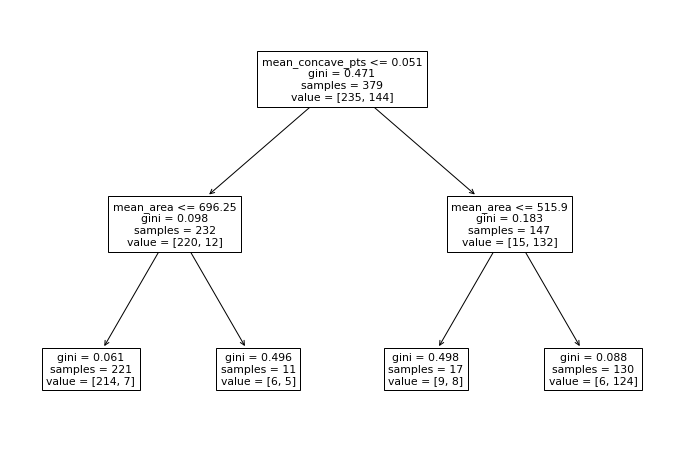

In [89]:
from sklearn.tree import plot_tree
plt.figure(figsize=(12, 8))
plot_tree(model, feature_names=X2d_train.columns.to_list());

- L'albero in pratica classifica un'istanza come "M" se `mean_concave_pts > 0.05` e `mean_area > 515.90`
- Creiamo come sopra una visualizzazione delle probabilità
  - in ogni nodo è associata una distribuzione di probabilità pari a quella delle istanze di training catturate dal nodo

/home/pasolini/.venvs/dia/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


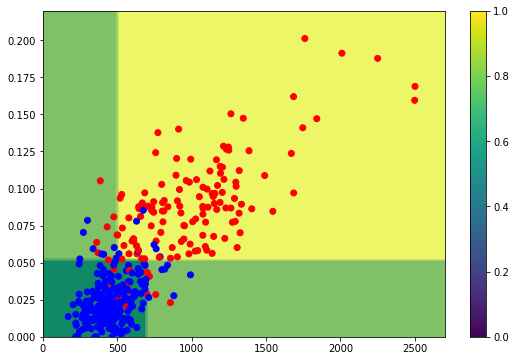

In [90]:
# estraggo un campione di 100x100 punti nel piano
mx1, mx2 = np.meshgrid(np.linspace(0, 2700, 100), np.linspace(0, 0.22, 100))
# estraggo le probabilità della classe M per ciascun punto
my = model.predict_proba(np.c_[mx1.ravel(), mx2.ravel()])[:, 1].reshape(mx1.shape)
# disegno il grafico
plt.figure(figsize=(9, 6))
plt.contourf(mx1, mx2, my, cmap="summer")
plt.scatter(*X2d_train.values.T, c=y_train.map(diagnosis_color_map))
plt.colorbar();

- L'accuratezza è in questo caso simile a quella degli altri modelli

In [91]:
model.score(X2d_val, y_val)

0.8947368421052632

- Non limitando la profondità dell'albero si crea una suddivisione dello spazio dei dati molto fine, che spesso però costituisce overfitting

In [92]:
model = DecisionTreeClassifier()
model.fit(X2d_train, y_train);

In [93]:
model.score(X2d_val, y_val)

0.8947368421052632

/home/pasolini/.venvs/dia/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


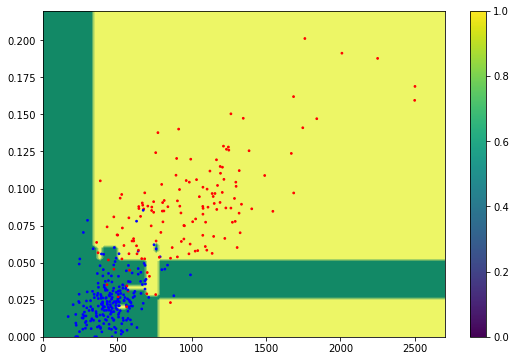

In [94]:
mx1, mx2 = np.meshgrid(np.linspace(0, 2700, 100), np.linspace(0, 0.22, 100))
my = model.predict_proba(np.c_[mx1.ravel(), mx2.ravel()])[:, 1].reshape(mx1.shape)
plt.figure(figsize=(9, 6))
plt.contourf(mx1, mx2, my, cmap="summer")
plt.scatter(*X2d_train.values.T, c=y_train.map(diagnosis_color_map), s=3)
plt.colorbar();

/home/pasolini/.venvs/dia/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


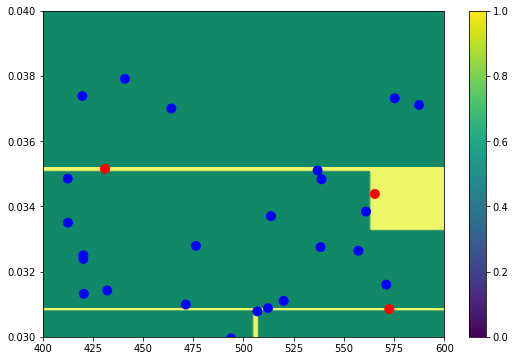

In [95]:
# zoom su una porzione di grafico
xlim = (400, 600)
ylim = (0.03, 0.04)
mx1, mx2 = np.meshgrid(np.linspace(*xlim, 200), np.linspace(*ylim, 200))
my = model.predict_proba(np.c_[mx1.ravel(), mx2.ravel()])[:, 1].reshape(mx1.shape)
plt.figure(figsize=(9, 6))
plt.contourf(mx1, mx2, my, cmap="summer")
plt.scatter(*X2d_train.values.T, c=y_train.map(diagnosis_color_map), s=80)
plt.xlim(xlim); plt.ylim(ylim)
plt.colorbar();

## Esercizio 5: Addestramento sul dataset completo

Effettuiamo ora esperimenti sul dataset completo con tutte le 30 variabili

In [96]:
X = bcwds.drop(columns="diagnosis")
y = bcwds["diagnosis"]

- **(5a)** Addestrare un modello di regressione logistica con standardizzazione dei dati e regolarizzazione L1 con C=0.1 e stampare i pesi del modello etichettati con i nomi delle colonne
  - verificare quante e quali delle 30 colonne risultano significative
- **(5b)** Effettuare una grid search per ricercare i parametri migliori della regressione logistica sull'intero set di dati con cross-validation a 3 fold stratificati (riutilizzare l'oggetto `skf` sopra), testando tutte le configurazioni significative e stampando i dettagli delle 5 con migliore accuratezza
  - con e senza standardizzazione dei dati
  - con regolarizzazione "l2", "l1", "elasticnet" o "none" (ne L1 ne L2)
  - con parametro C pari a 0.01, 0.1, 1, 10 o 100
  - con `l1_ratio` pari a 0.2 o 0.5

In [97]:
# usare una pipeline per effettuare la standardizzazione
from sklearn.pipeline import Pipeline